In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
import matplotlib.patches as mpatches

class ScratchSVMClassifier():
    """
    SVM classifier implementation from scratch
    
    Parameters
    ----------
    num_iter : int
        Number of iterations
    lr : float
        Learning rate
    kernel : str
        Type of kernel. Linear kernel ('linear') or polynomial kernel ('poly')
    threshold : float
        Threshold for selecting support vectors
    verbose : bool
        If True, output the learning process
    C : float
        Regularization parameter
    """
    
    def __init__(self, num_iter=1000, lr=0.0001, kernel='linear', threshold=1e-5, 
                 verbose=False, gamma=1, theta0=0, d=1, C=1.0):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        self.theta0 = theta0
        self.d = d
        self.C = C  #regularization parameter
    
    def _kernel_function(self, x1, x2):
        """
        Compute the kernel function between two data points
        
        Parameters
        ----------
        x1 : ndarray
            First data point
        x2 : ndarray
            Second data point
        
        Returns
        -------
        float
            Kernel value
        """
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'poly':
            # Clip values to prevent overflow
            dot_product = np.clip(np.dot(x1, x2), -1e10, 1e10)
            return np.clip((self.gamma * dot_product + self.theta0) ** self.d, -1e10, 1e10)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Train the SVM classifier. If validation data is input, calculate accuracy for it at each iteration.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training data features
        y : ndarray, shape (n_samples, )
            Training data labels
        X_val : ndarray, shape (n_samples, n_features)
            Validation data features
        y_val : ndarray, shape (n_samples, )
            Validation data labels
        """
        n_samples = X.shape[0]
        
        # Convert labels to -1, 1 format for internal processing
        if set(np.unique(y)) != {-1, 1}:
            self.y_format = "01"  # Remember original format was 0,1
            y_processed = np.where(y == 0, -1, 1)
        else:
            self.y_format = "-11"  # Remember original format was -1,1
            y_processed = y.copy()
        
        # Initialize Lagrange multipliers
        self.lambdas = np.zeros(n_samples)
        
        # Store training data
        self.X_train = X
        self.y_train = y_processed
        
        # Precompute kernel matrix for efficiency
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self._kernel_function(X[i], X[j])
        
        # Training loop
        for iteration in range(self.iter):
            for i in range(n_samples):
                # Calculate gradient update using kernel trick
                # Clip values to prevent overflow
                sum_term = np.sum(self.lambdas * y_processed * kernel_matrix[i, :])
                sum_term = np.clip(sum_term, -1e10, 1e10)  # Prevent overflow
                update_term = 1 - sum_term
                
                # Update Lagrange multiplier
                self.lambdas[i] += self.lr * update_term
                
                # Enforce constraints: 0 <= lambda <= C
                self.lambdas[i] = np.clip(self.lambdas[i], 0, self.C)
            
            # Find support vectors
            sv_indices = np.where(self.lambdas > self.threshold)[0]
            
            if self.verbose and (iteration + 1) % (self.iter // 10) == 0:
                print(f"Iteration {iteration + 1}/{self.iter}, Support vectors: {len(sv_indices)}")
                
                if X_val is not None and y_val is not None:
                    # Store support vectors temporarily to make predictions
                    self.index_support_vectors = sv_indices
                    self.n_support_vectors = len(sv_indices)
                    self.X_sv = X[sv_indices]
                    self.lam_sv = self.lambdas[sv_indices]
                    self.y_sv = y_processed[sv_indices]
                    
                    # Predict and calculate accuracy
                    y_pred = self.predict(X_val)
                    
                    # Convert validation labels to match prediction format if needed
                    if self.y_format == "01" and set(np.unique(y_val)) != {-1, 1}:
                        # No conversion needed as predict already returns in original format
                        pass
                    elif self.y_format == "01" and set(np.unique(y_val)) == {-1, 1}:
                        y_val_adjusted = np.where(y_val == -1, 0, 1)
                        accuracy = accuracy_score(y_val_adjusted, y_pred)
                    elif self.y_format == "-11" and set(np.unique(y_val)) != {-1, 1}:
                        y_val_adjusted = np.where(y_val == 0, -1, 1)
                        accuracy = accuracy_score(y_val_adjusted, y_pred)
                    else:
                        accuracy = accuracy_score(y_val, y_pred)
                    
                    print(f"Validation accuracy: {accuracy:.4f}")
        
        # Final support vectors
        self.index_support_vectors = np.where(self.lambdas > self.threshold)[0]
        self.n_support_vectors = len(self.index_support_vectors)
        self.X_sv = X[self.index_support_vectors]
        self.lam_sv = self.lambdas[self.index_support_vectors]
        self.y_sv = y_processed[self.index_support_vectors]
        
        if self.verbose:
            print(f"\nTraining completed with {self.n_support_vectors} support vectors")
    
    def predict(self, X):
        """
        Use the SVM classifier to predict labels.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Samples
        
        Returns
        -------
        ndarray, shape (n_samples, 1)
            Prediction results from the SVM classifier in the original label format
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)
        
        for i in range(n_samples):
            f_x = 0
            for j in range(self.n_support_vectors):
                sv_x = self.X_sv[j]
                sv_y = self.y_sv[j]
                sv_lambda = self.lam_sv[j]
                
                # Apply kernel function
                kernel_value = self._kernel_function(X[i], sv_x)
                
                # Sum up contributions from all support vectors
                # Clip to prevent overflow
                contribution = sv_lambda * sv_y * kernel_value
                contribution = np.clip(contribution, -1e10, 1e10)
                f_x += contribution
            
            # Sign function to determine the class
            predictions[i] = 1 if f_x >= 0 else -1
        
        # Convert back to original label format if needed
        if self.y_format == "01":
            return np.where(predictions == -1, 0, 1)
        else:
            return predictions

In [7]:
def visualize_decision_regions(svm, X, y, title="SVM Decision Regions"):
    """
    Visualize decision regions and highlight support vectors in different colors
    
    Parameters
    ----------
    svm : ScratchSVMClassifier
        Trained SVM classifier
    X : ndarray, shape (n_samples, 2)
        Feature data (must be 2-dimensional for visualization)
    y : ndarray, shape (n_samples,)
        Label data
    title : str
        Plot title
    """
    # Create a mesh grid
    h = 0.08  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                          np.arange(y_min, y_max, h))
    
    # Predict for the entire mesh grid
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and data points
    plt.figure(figsize=(10, 8))
    
    # Plot decision regions with a colormap
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    
    # Draw decision boundary
    plt.contour(xx, yy, Z, colors='k', linestyles='-', linewidths=1)
    
    # Plot all data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu_r, edgecolors='k', alpha=0.7)
    
    # Highlight support vectors with a different color and larger size
    plt.scatter(svm.X_sv[:, 0], svm.X_sv[:, 1], s=120, 
                facecolors='none', edgecolors='green', linewidth=2,
                label='Support Vectors')
    class_0_patch = mpatches.Patch(color=plt.cm.RdBu_r(0), label="0")
    class_1_patch = mpatches.Patch(color=plt.cm.RdBu_r(255), label="1")
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)
    plt.legend(handles=[class_0_patch, class_1_patch], loc='upper right')
    plt.show()

In [8]:
def compare_with_sklearn(X_train, y_train, X_test, y_test, scratch_svm):
    """
    Compare scratch SVM with scikit-learn implementation
    
    Parameters
    ----------
    X_train : ndarray
        Training features
    y_train : ndarray
        Training labels
    X_test : ndarray
        Testing features
    y_test : ndarray
        Testing labels
    scratch_svm : ScratchSVMClassifier
        Trained scratch SVM
    """
    # Get predictions from scratch SVM
    scratch_predictions = scratch_svm.predict(X_test)
    
    # Train sklearn SVM
    sklearn_svm = SVC(kernel='linear' if scratch_svm.kernel == 'linear' else 'poly',
                      degree=scratch_svm.d if scratch_svm.kernel == 'poly' else 3,
                      gamma='scale' if scratch_svm.kernel == 'poly' else 'auto',
                      C=scratch_svm.C)
    sklearn_svm.fit(X_train, y_train)
    sklearn_predictions = sklearn_svm.predict(X_test)
    
    # Calculate metrics - handle zero division in case prediction is all one class
    scratch_accuracy = accuracy_score(y_test, scratch_predictions)
    sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
    
    scratch_precision = precision_score(y_test, scratch_predictions, average='weighted', zero_division=0)
    sklearn_precision = precision_score(y_test, sklearn_predictions, average='weighted', zero_division=0)
    
    scratch_recall = recall_score(y_test, scratch_predictions, average='weighted', zero_division=0)
    sklearn_recall = recall_score(y_test, sklearn_predictions, average='weighted', zero_division=0)
    
    # Print results
    print("=== Performance Comparison ===")
    print(f"Scratch SVM - Accuracy: {scratch_accuracy:.4f}, Precision: {scratch_precision:.4f}, Recall: {scratch_recall:.4f}")
    print(f"Sklearn SVM - Accuracy: {sklearn_accuracy:.4f}, Precision: {sklearn_precision:.4f}, Recall: {sklearn_recall:.4f}")
    print(f"Support vectors - Scratch: {scratch_svm.n_support_vectors}, Sklearn: {len(sklearn_svm.support_)}")
    
    return {
        'scratch': {
            'accuracy': scratch_accuracy,
            'precision': scratch_precision,
            'recall': scratch_recall,
            'n_sv': scratch_svm.n_support_vectors
        },
        'sklearn': {
            'accuracy': sklearn_accuracy,
            'precision': sklearn_precision,
            'recall': sklearn_recall,
            'n_sv': len(sklearn_svm.support_)
        }
    }


Training SVM with linear kernel...
Iteration 100/1000, Support vectors: 404
Iteration 200/1000, Support vectors: 404
Iteration 300/1000, Support vectors: 404
Iteration 400/1000, Support vectors: 404
Iteration 500/1000, Support vectors: 404
Iteration 600/1000, Support vectors: 404
Iteration 700/1000, Support vectors: 404
Iteration 800/1000, Support vectors: 404
Iteration 900/1000, Support vectors: 404
Iteration 1000/1000, Support vectors: 404

Training completed with 404 support vectors

Visualizing decision regions...


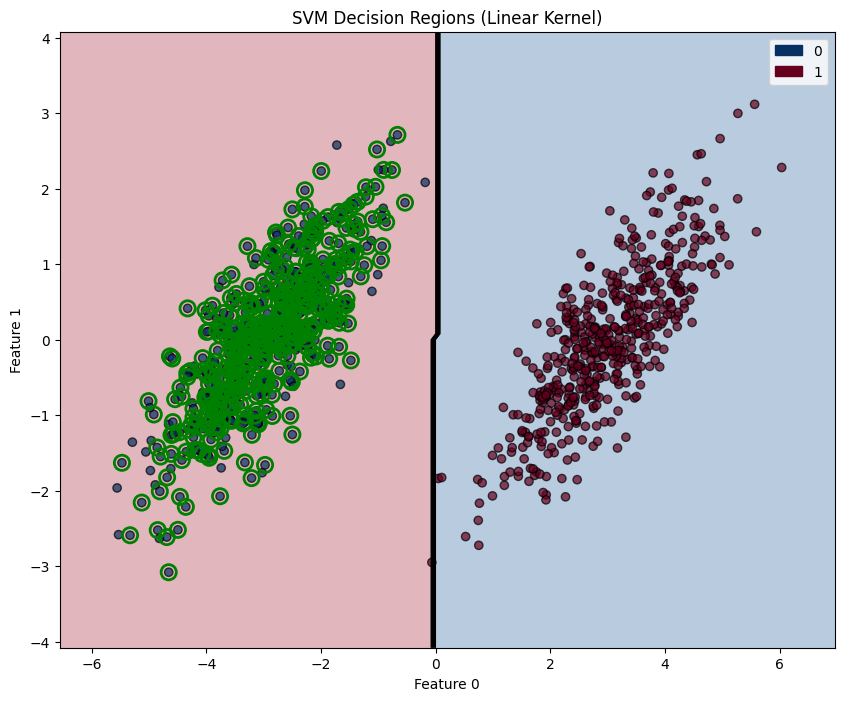


Comparing with scikit-learn SVM...
=== Performance Comparison ===
Scratch SVM - Accuracy: 0.9950, Precision: 0.9951, Recall: 0.9950
Sklearn SVM - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Support vectors - Scratch: 404, Sklearn: 3

Training SVM with polynomial kernel...
Iteration 100/1000, Support vectors: 512
Iteration 200/1000, Support vectors: 478
Iteration 300/1000, Support vectors: 468
Iteration 400/1000, Support vectors: 461
Iteration 500/1000, Support vectors: 459
Iteration 600/1000, Support vectors: 457
Iteration 700/1000, Support vectors: 454
Iteration 800/1000, Support vectors: 452
Iteration 900/1000, Support vectors: 451
Iteration 1000/1000, Support vectors: 451

Training completed with 451 support vectors


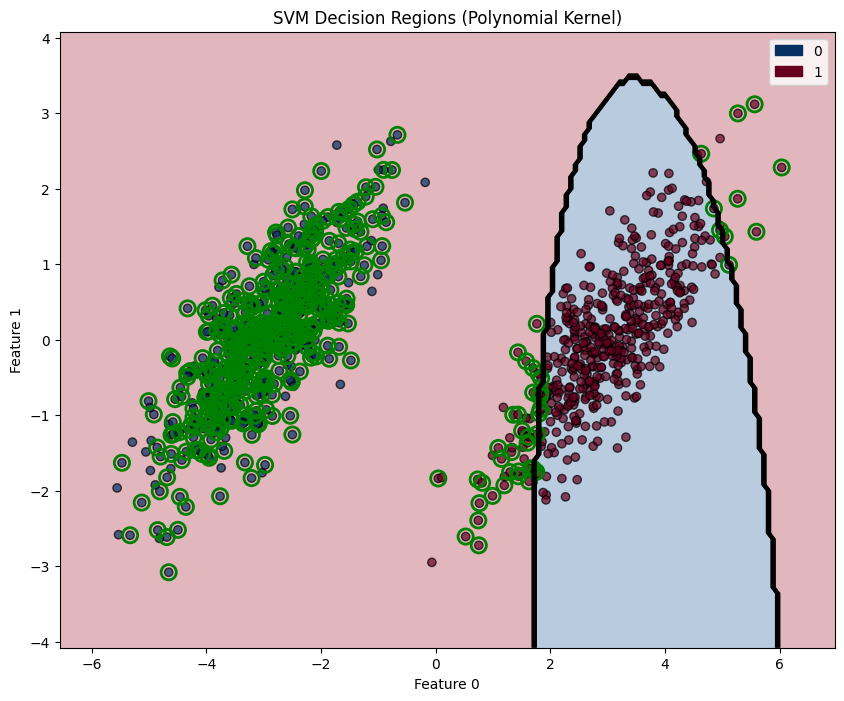

In [9]:
def main():
    # Set random seed for reproducibility
    np.random.seed(0)
    
    # Create first dataset - class 0
    mean1 = [-3, 0]  # Mean for first dataset
    covariance = [[1.0, 0.8], [0.8, 1.0]]  
    data1 = np.random.multivariate_normal(mean1, covariance, 500)
    
    # Create second dataset - class 1
    mean2 = [3, 0]  # Mean for second dataset
    data2 = np.random.multivariate_normal(mean2, covariance, 500)
    
    # Combine datasets - use 0 and 1 labels instead of -1 and 1
    X = np.vstack([data1, data2])
    y = np.hstack([np.zeros(500), np.ones(500)])  # 0 for first class, 1 for second class
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train scratch SVM with linear kernel
    print("Training SVM with linear kernel...")
    svm_linear = ScratchSVMClassifier(
        num_iter=1000, 
        lr=0.0001,  
        kernel='linear', 
        threshold=1e-5, 
        verbose=True,
        C=1.0  
    )
    svm_linear.fit(X_train, y_train)
    
    # Visualize decision regions
    print("\nVisualizing decision regions...")
    visualize_decision_regions(svm_linear, X, y, title="SVM Decision Regions (Linear Kernel)")
    
    # Compare with sklearn
    print("\nComparing with scikit-learn SVM...")
    results = compare_with_sklearn(X_train, y_train, X_test, y_test, svm_linear)
    
    # Optional: Try polynomial kernel as well
    print("\nTraining SVM with polynomial kernel...")
    svm_poly = ScratchSVMClassifier(
        num_iter=1000, 
        lr=0.0001,  
        kernel='poly', 
        threshold=1e-5, 
        verbose=True, 
        gamma=0.1, 
        theta0=1, 
        d=2,
        C=1.0  
    )
    svm_poly.fit(X_train, y_train)
    visualize_decision_regions(svm_poly, X, y, title="SVM Decision Regions (Polynomial Kernel)")
    
    return svm_linear, svm_poly, X, y, results

if __name__ == "__main__":
    svm_linear, svm_poly, X, y, results = main()